In [1]:
import sys
import math
import anndata

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [4]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

In [5]:
import pandas as pd 
import numpy as np

# Somatic early

### Read in sanger dataset

In [6]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

### Load Niu dataset

In [7]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

## Merge datasets

In [8]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

## Subset cells

In [9]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse_females_scVIintegrated_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/mouse_males_scVIintegrated_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.index = [i+"-Sanger" for i in metaM.index]
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
adata.obs['lineage'].values.describe()

counts     freqs
categories                          
CoelEpi_Gata2         5258  0.048838
CoelEpi_Lhx9          8267  0.076787
Endothelial           2210  0.020527
Epithelial            7966  0.073992
Epithelial_Wnt7a      1222  0.011350
Erythroid             1273  0.011824
FetalLeydig            184  0.001709
GermCells             6207  0.057653
Immune                1287  0.011954
Mesenchymal_Crabp1   12262  0.113895
Mesenchymal_Gata2    14851  0.137942
Mesenchymal_Lhx9     15441  0.143422
Neural                1971  0.018307
PV                     940  0.008731
SMCs                   827  0.007682
Sertoli               1493  0.013868
Supporting           20294  0.188499
cont                  4210  0.039104
lowQC                 1498  0.013914

In [11]:
# adata = adata[[i in ['10.5', '11.5', "E11.5"] for i in adata.obs.stage ]]
adata = adata[[i in ['Supporting', 'Sertoli', 'CoelEpi_Lhx9', 'Mesenchymal_Lhx9', 'FetalLeydig'] for i in adata.obs.lineage]]
adata.obs['lineage'].values.describe()

counts     freqs
categories                        
CoelEpi_Lhx9        8267  0.180980
FetalLeydig          184  0.004028
Mesenchymal_Lhx9   15441  0.338033
Sertoli             1493  0.032685
Supporting         20294  0.444274

In [12]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_scVI_somatic_annotation.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')

Trying to set attribute `.obs` of view, copying.


In [13]:
sc.pp.filter_genes(adata, min_counts=3)

### OPTIONAL - Remove cc genes

In [14]:
# ccgs defined in M1
adata = adata[:,[i not in sanger.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 23920


### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [15]:
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=2000,
#     subset=False,
#     flavor="seurat_v3"
# )
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key='stage'
)

Trying to set attribute `.uns` of view, copying.


In [16]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

In [17]:
'Sry' in bdata.var_names

False

In [18]:
'Foxl2' in bdata.var_names

True

## Normalize - optional

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [20]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='dataset',
    categorical_covariate_keys=["stage"] 
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["dataset"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 45679 cells, 2000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [21]:
model = scvi.model.SCVI(bdata, n_latent= 10)
# model = scvi.model.SCVI(bdata, n_latent= 60)

In [22]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [23]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 175/175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [21:11<00:00,  7.27s/it, loss=981, v_num=1]


In [24]:
latent = model.get_latent_representation()

In [25]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [26]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/mouse-gonads_XscVI_latent_somatic.csv')
pd.DataFrame(adata.obs).to_csv(path_to_gonads+'/mouse-gonads_XscVI_latentMeta_somatic.csv')

### Visualization and Clustering

In [27]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(adata, min_dist=0.4)

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

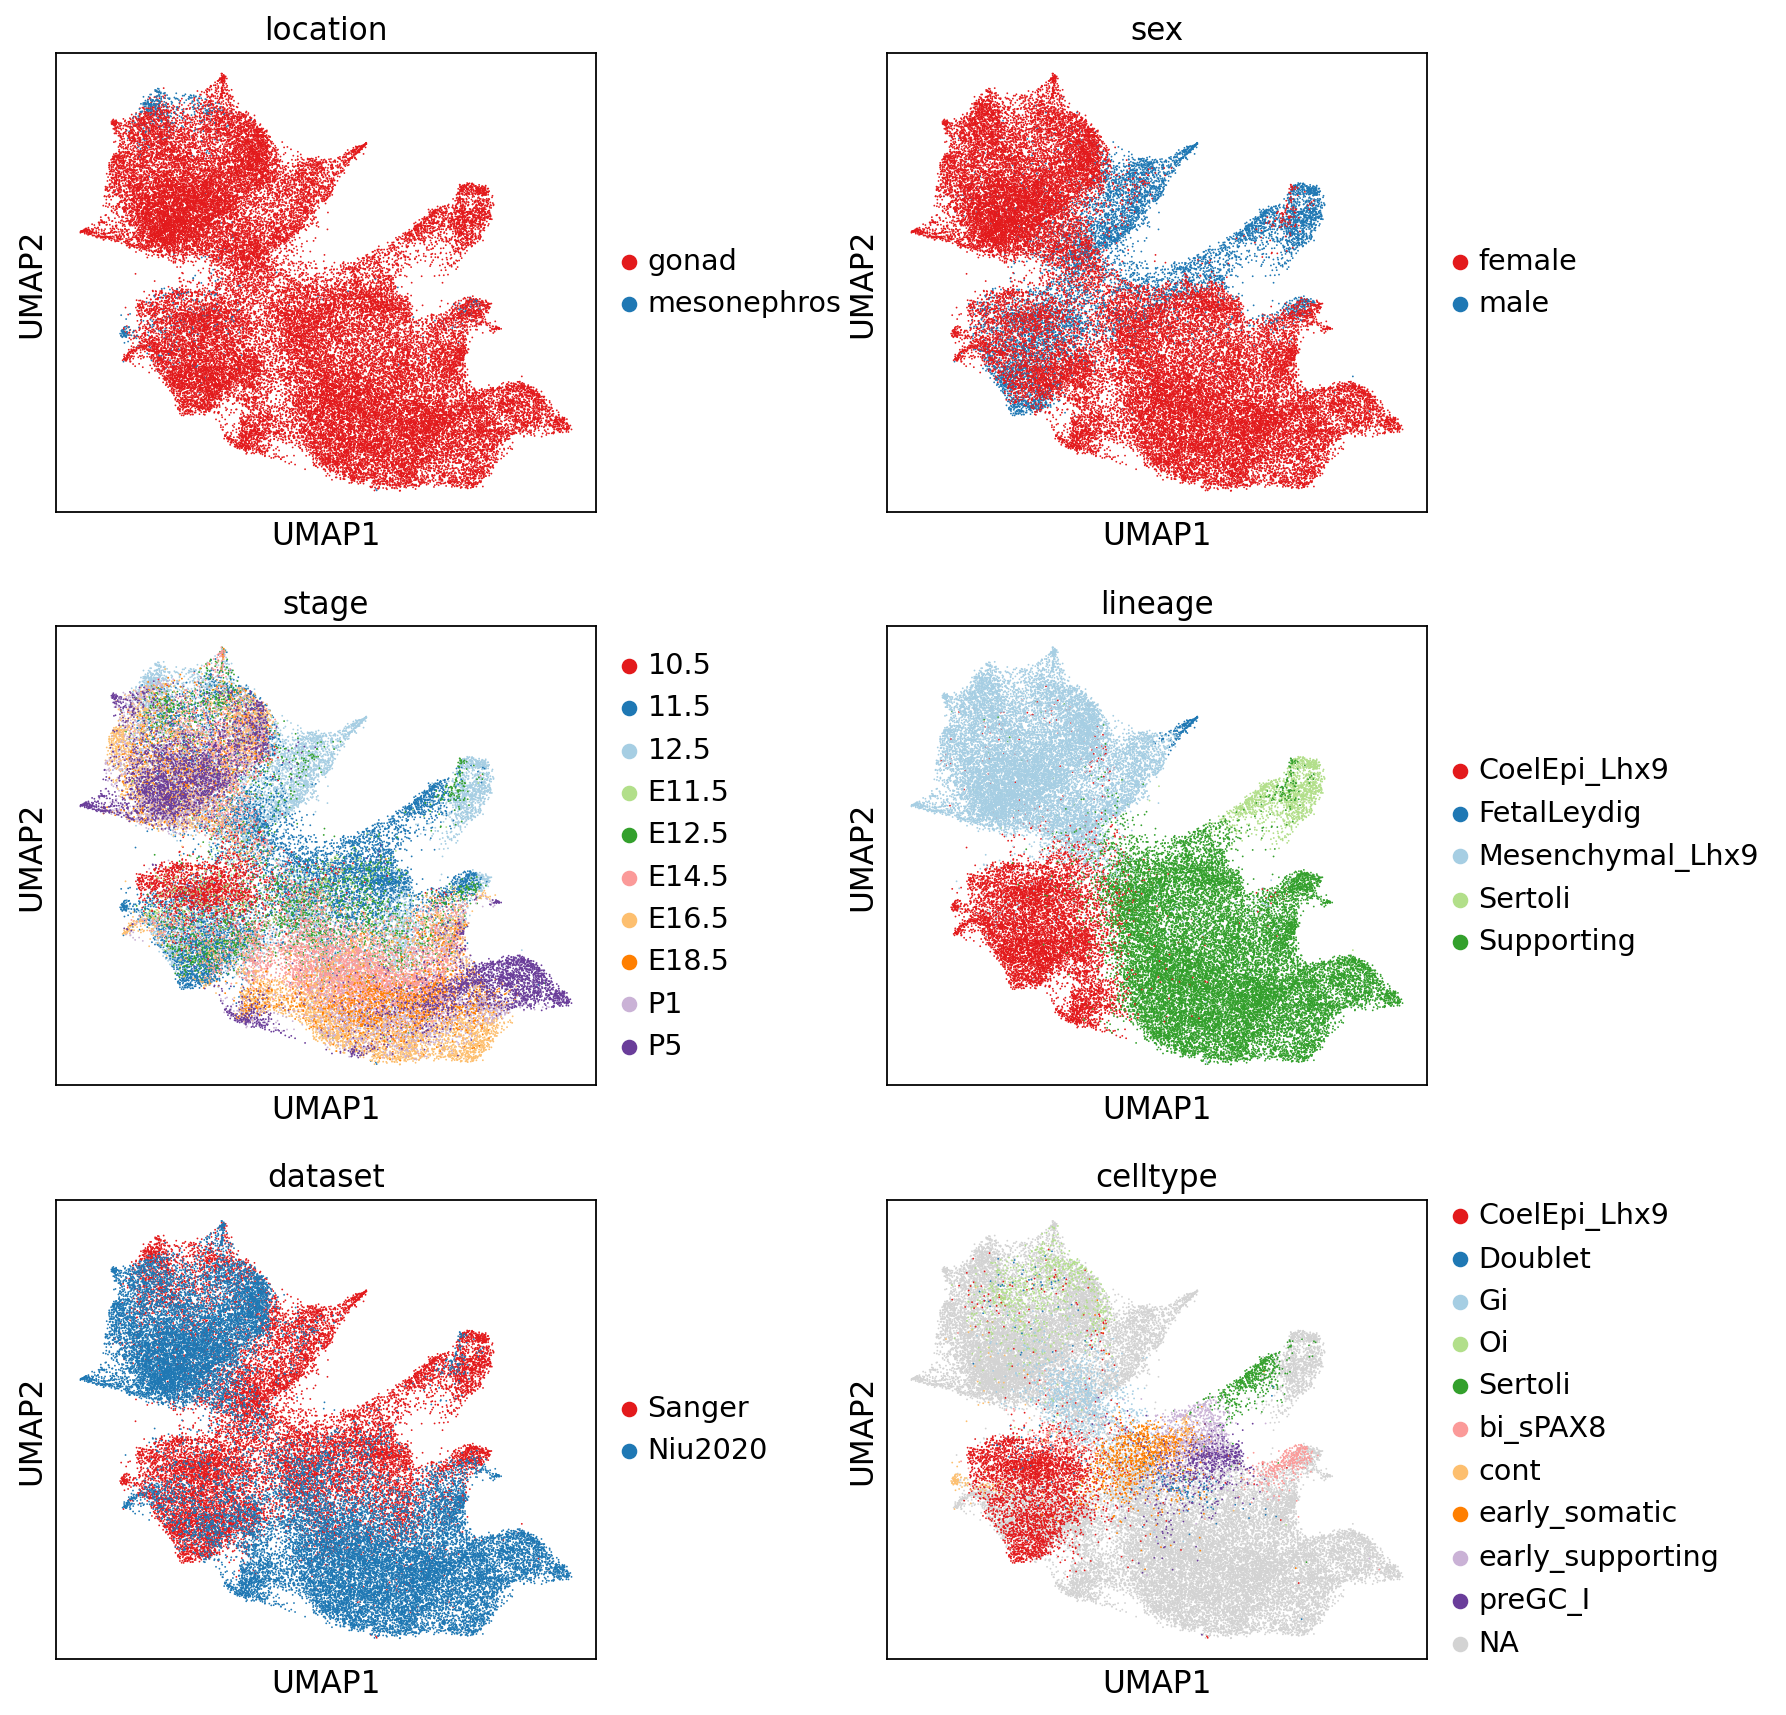

In [28]:
sc.pl.umap(
    adata,
    color=[ "location",  'sex', 'stage', "lineage", 'dataset', 'celltype'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.4
)

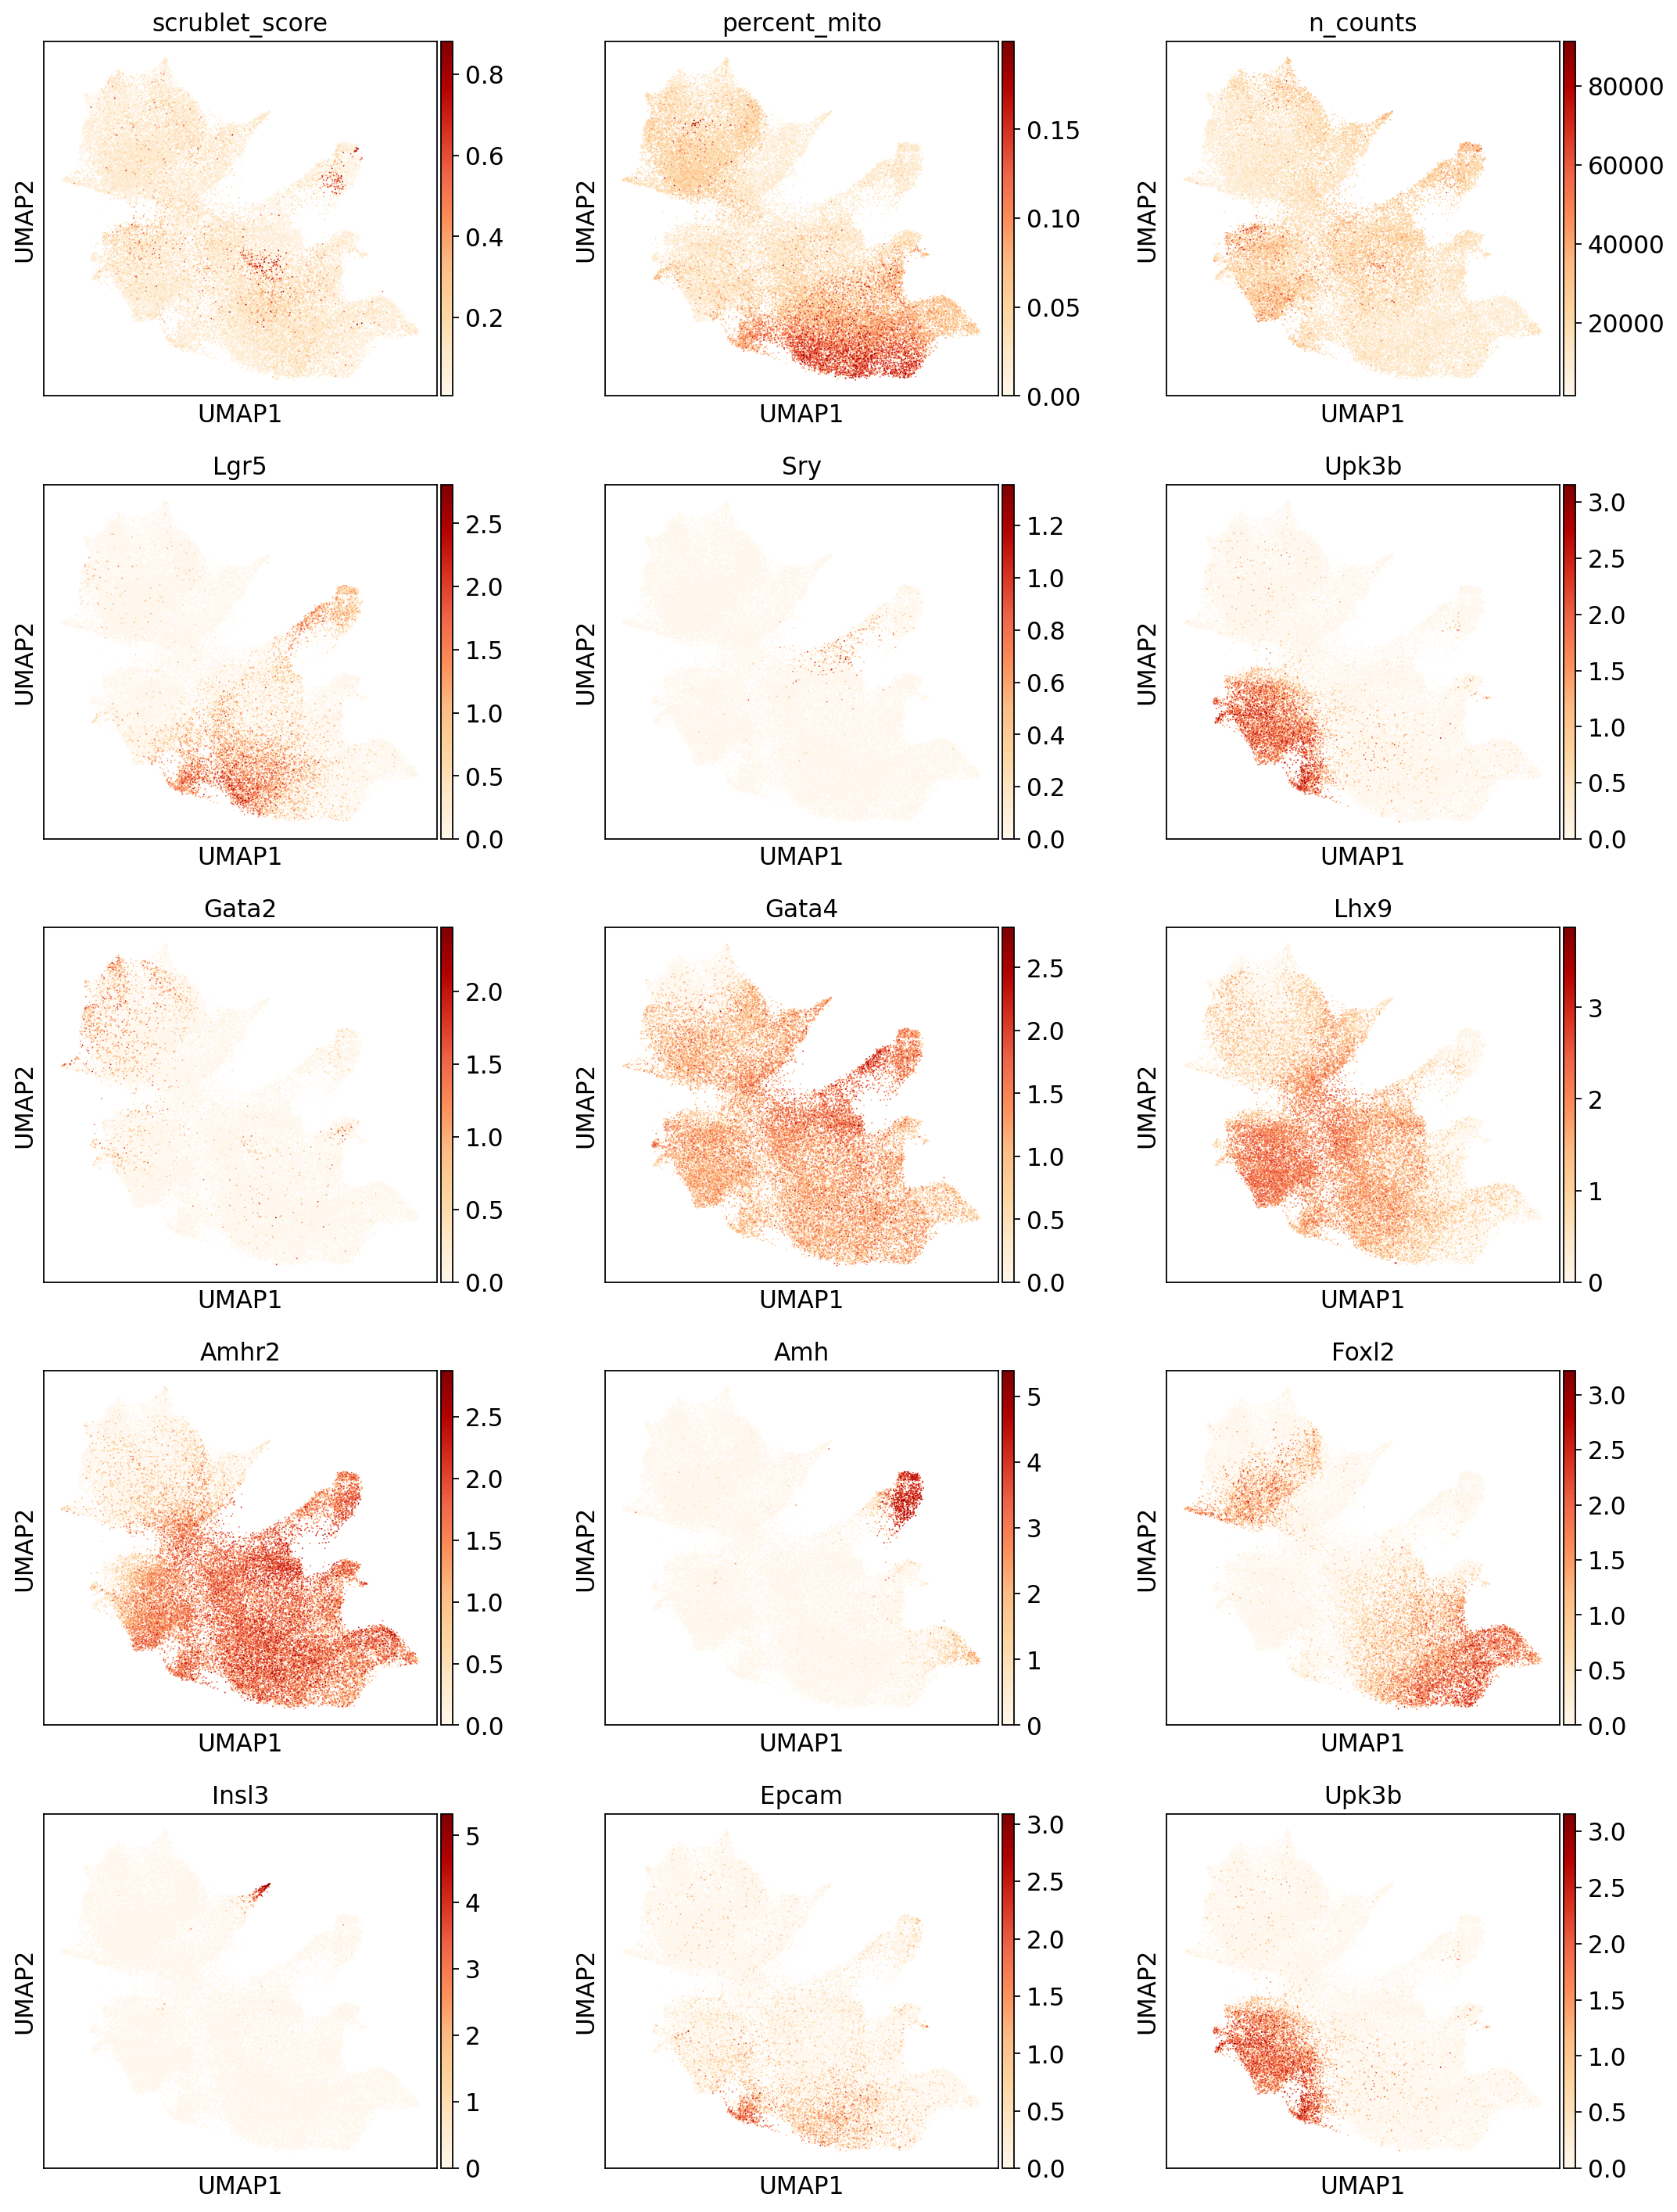

In [29]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts', 'Lgr5', 'Sry', 'Upk3b','Gata2', 'Gata4', 'Lhx9',  'Amhr2', 'Amh', 'Foxl2',  'Insl3', 'Epcam', 'Upk3b'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)